In [1]:
# Importing libraries for operations

import os
import warnings
import findspark
import seaborn as sns
import pandas as pd
import pyspark.pandas as ps
import matplotlib.pyplot as plt

from pprint import pprint
from pymongo import MongoClient

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import when, count
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import mean, desc

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
findspark.init()

C:\Users\Ganer\AppData\Roaming\Python\Python39\site-packages\pyspark\pandas\__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(



# <strong><center>Predicting Customer Conversion on Bank Telemarketing Dataset</center></strong>

<div class="alert alert-info"><strong>TODAY:</strong> While bank marketing campaigns have largely remained traditional, standard bank advertising is boring for both marketers and their consumers. Thinking outside the box and implementing creative marketing ideas for banks will help you to develop creative campaigns, benefiting your bank, consumer engagement, and likely the success of the actual bank marketing campaigns as well.

Most consumers see banking as a mundane necessity, something they’d rather avoid if they could. Taking a creative approach to bank marketing campaigns might change that, especially if you integrate creative marketing ideas for banks like gamification, automation, chatbots, and rewards so that consumers are motivated to use your services.</div>

In [2]:
# Setting path for working

try:
    # Getting the current working directory
    cwd = os.getcwd()
    
    # Printing the current working directory
    print("The current directory is: {0}".format(cwd))

    # Changing the current working directory
    os.chdir(cwd)
    
    print("The current working directory was set succesfully!")

except:
    print("OOPs!! The current working directory was not set succesfully...")

The current directory is: D:\Lemonrice\virtual_demo\Lemonrice_mongo_connectivity
The current working directory was set succesfully!


## Using API from Kaggle to download dataset

In [129]:
use_kaggle_API = False
if use_kaggle_API:
    # downloading the dataset
    !kaggle datasets download -d princeganer/bank-telemarketing-dataset

    # unzipping the downloaded dataset
    !unzip bank-telemarketing-dataset.zip

In [3]:
# the zipped as well as unzipped files can be seen
!dir

print("\n\nAbove files and folders are present in the working directory.")

 Volume in drive D is Storage
 Volume Serial Number is E457-CEE6

 Directory of D:\Lemonrice\virtual_demo\Lemonrice_mongo_connectivity

05/04/2023  00:30    <DIR>          .
05/04/2023  00:30    <DIR>          ..
05/04/2023  00:18    <DIR>          .ipynb_checkpoints
10/03/2023  08:52         5,834,924 bank-additional-full.csv
10/03/2023  08:52             5,458 bank-additional-names.txt
10/03/2023  08:52         4,610,348 bank-full.csv
01/04/2023  10:52           927,049 bank-telemarketing-dataset.zip
01/04/2023  13:57        33,894,275 bankmkt.json
10/03/2023  08:52                94 info.txt
01/04/2023  01:56             7,944 Lemonrice_mDB-pro_3_31_1.ipynb
04/04/2023  13:40           583,394 Spark_4_4_2_copy-pylint-test.ipynb
04/04/2023  14:01            37,418 Spark_4_4_2_copy-pylint-test.py
04/04/2023  11:33           583,389 Spark_Bank_Campaign_4_1_1.ipynb
05/04/2023  00:30            62,279 Spark_Bank_Campaign_4_4_23-Copy1.ipynb
05/04/2023  00:18           584,902 Spark_Bank_Ca

<div class="alert alert-info">Sucessfully imported data using Kaggle's API</div>

In [4]:
# Create a sparksession
spark = SparkSession.builder \
    .master('local[4]') \
    .appName('Lemonrice') \
    .getOrCreate()

In [5]:
# Ignore warnings coming from Arrow optimizations.
warnings.filterwarnings("ignore")

# To speed up dataset processing
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

# full width display for spark dataframe
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

# full columns display columns in pyspark's pandas
pd.pandas.set_option('display.max_columns', None)

# Use default index prevent overhead
ps.set_option("compute.default_index_type", "distributed")

## Data Preprocessing

#### Bank Full (dataset-1) <br>


`bank-full.csv` Bank Full Preprocessing

Header | Definition
---|---------
`Age`| Age of the client
`Job` | Job type of the client
`Martial` | Martial status of the client  
`Education` | Client's highest education level
`Default` |  Does the customer have credit in default?
`Balance` | Client's individual balance
`Housing` | Does the client have housing loan
`Loan` | Does the client have personal Loan
`Contact` | Communication type of contact with customer
`Day` | Last contact day of the week
`Month` |  Last contact month of year 
`Duration` | Last contact duration (in seconds)
`Campaign` | Number of contacts performed during this campaign and for this client
`Pdays` | Number of days that passed by after the client was last contacted from a previous campaign
`Previous` | Number of contacts performed before this campaign and for this client
`Poutcome` | Outcome of the previous marketing campaign 
`y` | Has the client subscribed for a term deposit

In [6]:
# Read Spark Dataframe
bank_full = spark.read.csv('bank-full.csv', sep = ";",
                           header = True, inferSchema = True)

In [7]:
bank_full.count()

45211

In [8]:
display(bank_full.limit(5))

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
bank_full.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [10]:
# Adding the social metric index columns
new_cols = ["emp_var_rate", "cons_price_idx",
            "cons_conf_idx", "euribor_3m", "nr_employed"]

for column in new_cols:
    bank_full = bank_full.withColumn(column,
                                     bank_full["poutcome"] + 1)
    
display(bank_full.limit(5))

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,null,null,null,null,null
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,null,null,null,null,null
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,null,null,null,null,null
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,null,null,null,null,null
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,null,null,null,null,null


In [11]:
# map years to a dataframe

def year_mapper(data, start_yr, end_yr):
    """
        This function takes dataframe, start year of data, end year of data
        as input and returns a new dataframe having year column mapped to it.
    """
    month_lst = ["jan", "feb", "mar", "apr", "may", "jun",
                 "jul", "aug", "sep", "oct", "nov", "dec"]

    # Make a copy of the original dataframe
    new_data = data.copy()

    # Insert a new "year" column filled with zeros
    new_data.insert(loc = 0, 
                    column = "year", value = 0)

    # Set the first year to the start year
    current_year = int(start_yr)
    new_data.at[0, "year"] = current_year

    # Loop through the rows of the dataframe, updating the year column when the month changes
    for i in range(1, len(new_data)):
        # If the current month is earlier in the year than the previous month, increment the year
        if month_lst.index(new_data["month"][i]) < month_lst.index(new_data["month"][i-1]):
            current_year += 1

        new_data.at[i, "year"] = current_year

        # If the current year exceeds the end year, break out of the loop
        if current_year > end_yr:
            break

    return new_data

In [12]:
bank_full_pdf = bank_full.toPandas()

# Applying year mapper function to the Pandas DataFrame
new_pandas_df = year_mapper(bank_full_pdf, 2008, 2010)

# Convert the updated Pandas DataFrame back to a PySpark DataFrame
bank_full = spark.createDataFrame(new_pandas_df)

In [13]:
display(bank_full.limit(5))

year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,null,null,null,null,null
2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,null,null,null,null,null
2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,null,null,null,null,null
2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,null,null,null,null,null
2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,null,null,null,null,null


In [14]:
bank_full.groupBy("year").count().show()

+----+-----+
|year|count|
+----+-----+
|2008|27729|
|2009|14862|
|2010| 2620|
+----+-----+



### Social metric Index mapper

In [15]:
# Function 'map_index' for adding the missing social metric index values into the dataframe

def map_index(new_data):

    index_2008 = {"may":{"emp_var_rate":1.1, "cons_price_idx":93.994, "cons_conf_idx":-36.4, "euribor_3m":4.85, "nr_employed":5191},
                 "jun":{"emp_var_rate":1.4, "cons_price_idx":94.465, "cons_conf_idx":-41.8, "euribor_3m":4.86, "nr_employed":5228.1},
                 "jul":{"emp_var_rate":1.4, "cons_price_idx":93.918, "cons_conf_idx":-42.7, "euribor_3m":4.96, "nr_employed":5228.1},
                 "aug":{"emp_var_rate":1.4, "cons_price_idx":93.444, "cons_conf_idx":-36.1, "euribor_3m":4.965, "nr_employed":5228.1},
                 "oct":{"emp_var_rate":-0.1, "cons_price_idx":93.798, "cons_conf_idx":-40.4, "euribor_3m":5, "nr_employed":5195.8},
                 "nov":{"emp_var_rate":-0.1, "cons_price_idx":93.2, "cons_conf_idx":-42, "euribor_3m":4.406, "nr_employed":5195.8},
                 "dec":{"emp_var_rate":-0.2, "cons_price_idx":92.75, "cons_conf_idx":-45.9, "euribor_3m":3.563, "nr_employed":5176.3}}

    index_2009 = {"jan":{"emp_var_rate":-0.2, "nr_employed":5176.3},
                  "feb":{"emp_var_rate":-0.2, "nr_employed":5176.3},
                  "mar":{"emp_var_rate":-1.8, "cons_price_idx":92.84, "cons_conf_idx":-50, "euribor_3m":1.811, "nr_employed":5099.1},
                  "apr":{"emp_var_rate":-1.8, "cons_price_idx":93.075, "cons_conf_idx":-47.1, "euribor_3m":1.498, "nr_employed":5099.1},
                  "may":{"emp_var_rate":-1.8, "cons_price_idx":92.89, "cons_conf_idx":-46.2, "euribor_3m":1.334, "nr_employed":5099.1},
                  "jun":{"emp_var_rate":-2.9, "cons_price_idx":92.963, "cons_conf_idx":-40.8, "euribor_3m":1.26, "nr_employed":5076.2},
                  "jul":{"emp_var_rate":-2.9, "cons_price_idx":93.469, "cons_conf_idx":-33.6, "euribor_3m":1.072, "nr_employed":5076.2},
                  "aug":{"emp_var_rate":-2.9, "cons_price_idx":92.201, "cons_conf_idx":-31.4, "euribor_3m":0.884, "nr_employed":5076.2},
                  "sep":{"emp_var_rate":-3.4, "cons_price_idx":92.379, "cons_conf_idx":-29.8, "euribor_3m":0.813, "nr_employed":5017.5},
                  "oct":{"emp_var_rate":-3.4, "cons_price_idx":92.431, "cons_conf_idx":-26.9, "euribor_3m":0.754, "nr_employed":5017.5},
                  "nov":{"emp_var_rate":-3.4, "cons_price_idx":92.649, "cons_conf_idx":-30.1, "euribor_3m":0.722, "nr_employed":5017.5},
                  "dec":{"emp_var_rate":-3.0, "cons_price_idx":92.713, "cons_conf_idx":-33, "euribor_3m":0.718, "nr_employed":5023.5}}

    index_2010 = {"jan":{"emp_var_rate":-3.0, "nr_employed":5023.5},
                  "feb":{"emp_var_rate":-3.0, "nr_employed":5023.5},
                  "mar":{"emp_var_rate":-1.8, "cons_price_idx":92.369, "cons_conf_idx":-34.8, "euribor_3m":0.655, "nr_employed":5008.7},
                  "apr":{"emp_var_rate":-1.8, "cons_price_idx":93.749, "cons_conf_idx":-34.6, "euribor_3m":0.64, "nr_employed":5008.7},
                  "may":{"emp_var_rate":-1.8, "cons_price_idx":93.876, "cons_conf_idx":-40, "euribor_3m":0.668, "nr_employed":5008.7},
                  "jun":{"emp_var_rate":-1.7, "cons_price_idx":94.055, "cons_conf_idx":-39.8, "euribor_3m":0.704, "nr_employed":4991.6},
                  "jul":{"emp_var_rate":-1.7, "cons_price_idx":94.215, "cons_conf_idx":-40.3, "euribor_3m":0.79, "nr_employed":4991.6},
                  "aug":{"emp_var_rate":-1.7, "cons_price_idx":94.027, "cons_conf_idx":-38.3, "euribor_3m":0.898, "nr_employed":4991.6},
                  "sep":{"emp_var_rate":-1.1, "cons_price_idx":94.199, "cons_conf_idx":-37.5, "euribor_3m":0.886, "nr_employed":4963.6},
                  "oct":{"emp_var_rate":-1.1, "cons_price_idx":94.601, "cons_conf_idx":-49.5, "euribor_3m":0.959, "nr_employed":4963.6},
                  "nov":{"emp_var_rate":-1.1, "cons_price_idx":94.767, "cons_conf_idx":-50.8, "euribor_3m":1.05, "nr_employed":4963.6}}

    indx = [index_2008, index_2009, index_2010]
    years = [2008, 2009, 2010]
    
    for i in range(len(years)):
        for months, indexes in indx[i].items():
            for index, index_val in indexes.items():
                new_data = new_data.withColumn(index, 
                    when((col('year') == years[i]) & (col('month') == months), index_val).otherwise(col(index))) 
    return new_data

In [16]:
# Calling the 'index_mapper' function
bank_full = map_index(new_data = bank_full)
display(bank_full.limit(5))

year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0


In [17]:
bank_full.printSchema()

root
 |-- year: long (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor_3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)



In [18]:
# Dropping the 'balance', 'day' column
bank_full = bank_full.drop("balance", "day")

In [19]:
bank_full.head()

Row(year=2008, age=58, job='management', marital='married', education='tertiary', default='no', housing='yes', loan='no', contact='unknown', month='may', duration=261, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no', emp_var_rate=1.1, cons_price_idx=93.994, cons_conf_idx=-36.4, euribor_3m=4.85, nr_employed=5191.0)

In [20]:
# Converting the dataframe into the pandas dataframe
dataframe_1 = bank_full.toPandas()

In [21]:
dataframe_1.head()

,year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
0,2008,58,management,married,tertiary,no,yes,no,unknown,may,261,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
1,2008,44,technician,single,secondary,no,yes,no,unknown,may,151,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2,2008,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,76,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
3,2008,47,blue-collar,married,unknown,no,yes,no,unknown,may,92,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
4,2008,33,unknown,single,unknown,no,no,no,unknown,may,198,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0


In [23]:
# Rearranging the columns of the dataframe for uniformity
temp_cols = dataframe_1.columns.tolist()
print(temp_cols)

index = dataframe_1.columns.get_loc("y")

reordered_cols = temp_cols[: index] \
                 + temp_cols[index + 1:] \
                 + temp_cols[index:index + 1]

dataframe_1 = dataframe_1[reordered_cols]
dataframe_1.head()

['year', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


,year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,2008,58,management,married,tertiary,no,yes,no,unknown,may,261,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
1,2008,44,technician,single,secondary,no,yes,no,unknown,may,151,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2,2008,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,76,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
3,2008,47,blue-collar,married,unknown,no,yes,no,unknown,may,92,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
4,2008,33,unknown,single,unknown,no,no,no,unknown,may,198,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no


In [24]:
dataframe_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            45211 non-null  int64  
 1   age             45211 non-null  int32  
 2   job             45211 non-null  object 
 3   marital         45211 non-null  object 
 4   education       45211 non-null  object 
 5   default         45211 non-null  object 
 6   housing         45211 non-null  object 
 7   loan            45211 non-null  object 
 8   contact         45211 non-null  object 
 9   month           45211 non-null  object 
 10  duration        45211 non-null  int32  
 11  campaign        45211 non-null  int32  
 12  pdays           45211 non-null  int32  
 13  previous        45211 non-null  int32  
 14  poutcome        45211 non-null  object 
 15  emp_var_rate    45211 non-null  float64
 16  cons_price_idx  41159 non-null  float64
 17  cons_conf_idx   41159 non-null 

#### Bank Additional Full (dataset-2) <br>

`bank-additional-full.csv` Bank Additional Full Preprocessing

Header | Definition
---|---------
`Age`| Age of the client
`Job` | Job type of the client
`Martial` | Martial status of the client  
`Education` | Client's highest education level
`Default` |  Does the customer have credit in default?
`Housing` | Does the client have housing loan
`Loan` | Does the client have personal Loan
`Contact` | Communication type of contact with customer
`Month` |  Last contact month of year
`Day_of_week` | Last contact day of the week
`Duration` | Last contact duration (in seconds)
`Campaign` | Number of contacts performed during this campaign and for this client
`Pdays` | Number of days that passed by after the client was last contacted from a previous campaign
`Previous` | Number of contacts performed before this campaign and for this client
`Poutcome` | Outcome of the previous marketing campaign 
`Emp_var_rate` | Employment variation rate - quarterly indicator
`Cons_price_idx` | Consumer price index - monthly indicator
`Cons.conf.idx` | Consumer confidence index - monthly indicator     
`Euribor3m` | Euribor 3 month rate - daily indicator
`Nr.employed` | Number of employees - quarterly indicator
`y` | Has the client subscribed for a term deposit?

In [25]:
# Read Spark Dataframe
bank_add_full = spark.read.csv('bank-additional-full.csv', sep = ";",
                               header = True, inferSchema = True)

In [26]:
bank_add_full.count()

41188

In [27]:
display(bank_add_full.limit(5))

age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [28]:
bank_full_pdf = bank_add_full.toPandas()

# Applying the 'year_mapper' function to the Pandas DataFrame
new_pandas_df = year_mapper(bank_full_pdf, 2008, 2010)

# Convert the updated Pandas DataFrame back to a PySpark DataFrame
bank_add_full = spark.createDataFrame(new_pandas_df)

### Renaming columns names

In [29]:
# Replacing the columns names
old_col_list = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
for i in range(0, len(old_col_list)):
    bank_add_full = bank_add_full.withColumnRenamed(old_col_list[i], new_cols[i])

In [30]:
display(bank_add_full)

year,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Replace values from 999 to -1 in pdays column

In [31]:
# Changing the values from 999 to -1
bank_add_full = bank_add_full.withColumn("pdays",
                                         when(col("pdays") == 999, -1) \
                                         .otherwise(col("pdays")))

In [32]:
# Renaming the category names from education columns
old_edu = ["basic.4y", "high.school", "basic.6y", "basic.9y",
           "university.degree", "professional.course"]
new_edu = ["basic_4y", "high_school", "basic_6y", "basic_9y",
           "university_degree" ,"professional_course"]

for i in range(0,6):
    bank_add_full = bank_add_full.withColumn("education",
                                             when(col("education") == old_edu[i], new_edu[i]) \
                                             .otherwise(col("education")))

In [33]:
display(bank_add_full.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,40,admin.,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [34]:
bank_full.printSchema()

root
 |-- year: long (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor_3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)



In [35]:
# Drop the column 'day_of week'
bank_add_full = bank_add_full.drop("day_of_week")

In [36]:
dataframe_2 = bank_add_full.toPandas()

In [37]:
dataframe_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            41188 non-null  int64  
 1   age             41188 non-null  int32  
 2   job             41188 non-null  object 
 3   marital         41188 non-null  object 
 4   education       41188 non-null  object 
 5   default         41188 non-null  object 
 6   housing         41188 non-null  object 
 7   loan            41188 non-null  object 
 8   contact         41188 non-null  object 
 9   month           41188 non-null  object 
 10  duration        41188 non-null  int32  
 11  campaign        41188 non-null  int32  
 12  pdays           41188 non-null  int32  
 13  previous        41188 non-null  int32  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [38]:
dataframe_2.head()

,year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,2008,56,housemaid,married,basic_4y,no,no,no,telephone,may,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,2008,57,services,married,high_school,unknown,no,no,telephone,may,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2008,37,services,married,high_school,no,yes,no,telephone,may,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,2008,40,admin.,married,basic_6y,no,no,no,telephone,may,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,2008,56,services,married,high_school,no,no,yes,telephone,may,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [39]:
dataframe_1.head()

,year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,2008,58,management,married,tertiary,no,yes,no,unknown,may,261,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
1,2008,44,technician,single,secondary,no,yes,no,unknown,may,151,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2,2008,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,76,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
3,2008,47,blue-collar,married,unknown,no,yes,no,unknown,may,92,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
4,2008,33,unknown,single,unknown,no,no,no,unknown,may,198,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no


# MongoDB connectivity

In [40]:
# Create a mongo client for connection to host and port
try:
    client = MongoClient("localhost", 27017)
    print("Connection Successful!!")
except:
    print("Could not connect to MongoDB")

Connection Successful!!


In [41]:
# Create a database or switch to an existing database
db_name = "telemarketing"
my_database = client[db_name]
print(my_database, end ='\n\n')

# Creating a collection
collection_name = "bankmkt"
my_collection = my_database[collection_name]
print(my_collection)

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'telemarketing')

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'telemarketing'), 'bankmkt')


In [42]:
%%time
# To prevent unnecessary insertion into MongoDB's database, using flag
run_MongoDB_insertion = False
if run_MongoDB_insertion:
    # Insert bank-full into the collection
    try:
        print("Attempting data insertion for bank-full")
        dataframe_1.reset_index(inplace = True)
        df1_dicti = dataframe_1.to_dict("records")
        my_collection.insert_many(df1_dicti)

        print("Dumping into MongoDB database '{0}' in collection '{1}' succesfull!" \
              .format(db_name, collection_name))

    except:
        print("OOPs!! Attempt for insertion of bank-full data failed.")
        print("Dumping into MongoDB database '{0}' in collection '{1}' unsuccesfull..." \
              .format(db_name, collection_name))
    
    print(100*'-')

    # Insert bank-additional full into the collection   
    try:
        print("Attempting data insertion for bank-additional-full")
        dataframe_2.reset_index(inplace = True)
        df2_dicti = dataframe_2.to_dict("records")
        my_collection.insert_many(df2_dicti)

        print("Dumping into MongoDB database '{0}' in collection '{1}' succesfull!"\
              .format(db_name, collection_name))

    except:
        print("OOPs!! Attempt for insertion of bank-additional-full data failed.")
        print("Dumping into MongoDB database '{0}' in collection '{1}' unsuccesfull...."\
              .format(db_name,collection_name))
    
    print(100*'-')

CPU times: total: 0 ns
Wall time: 0 ns


In [43]:
my_collection.count_documents({})

86399

In [44]:
cursor = my_collection.find({},
                            {'_id':0}
                           ).limit(5)
for document in cursor:
    pprint(document)

{'age': 58,
 'campaign': 1,
 'cons_conf_idx': -36.4,
 'cons_price_idx': 93.994,
 'contact': 'unknown',
 'default': 'no',
 'duration': 261,
 'education': 'tertiary',
 'emp_var_rate': 1.1,
 'euribor_3m': 4.85,
 'housing': 'yes',
 'index': 0,
 'job': 'management',
 'loan': 'no',
 'marital': 'married',
 'month': 'may',
 'nr_employed': 5191.0,
 'pdays': -1,
 'poutcome': 'unknown',
 'previous': 0,
 'y': 'no',
 'year': 2008}
{'age': 44,
 'campaign': 1,
 'cons_conf_idx': -36.4,
 'cons_price_idx': 93.994,
 'contact': 'unknown',
 'default': 'no',
 'duration': 151,
 'education': 'secondary',
 'emp_var_rate': 1.1,
 'euribor_3m': 4.85,
 'housing': 'yes',
 'index': 1,
 'job': 'technician',
 'loan': 'no',
 'marital': 'single',
 'month': 'may',
 'nr_employed': 5191.0,
 'pdays': -1,
 'poutcome': 'unknown',
 'previous': 0,
 'y': 'no',
 'year': 2008}
{'age': 33,
 'campaign': 1,
 'cons_conf_idx': -36.4,
 'cons_price_idx': 93.994,
 'contact': 'unknown',
 'default': 'no',
 'duration': 76,
 'education': 'sec

<div class="alert alert-info">Concatenated 2 dataframes into a single MongoDB collection and <br>
now reading directly from MongoDB's database.</div>

In [45]:
%%time
bank = ps.DataFrame(list(my_collection.find({}, {'_id':0})))
bank.set_index(['index'], inplace = True)
bank.head()

CPU times: total: 4.44 s
Wall time: 5.45 s


,year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
index,,,,,,,,,,,,,,,,,,,,,
0,2008,58,management,married,tertiary,no,yes,no,unknown,may,261,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
1,2008,44,technician,single,secondary,no,yes,no,unknown,may,151,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2,2008,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,76,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
3,2008,47,blue-collar,married,unknown,no,yes,no,unknown,may,92,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
4,2008,33,unknown,single,unknown,no,no,no,unknown,may,198,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no


In [46]:
bank.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 86399 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            86399 non-null  int64  
 1   age             86399 non-null  int64  
 2   job             86399 non-null  object 
 3   marital         86399 non-null  object 
 4   education       86399 non-null  object 
 5   default         86399 non-null  object 
 6   housing         86399 non-null  object 
 7   loan            86399 non-null  object 
 8   contact         86399 non-null  object 
 9   month           86399 non-null  object 
 10  duration        86399 non-null  int64  
 11  campaign        86399 non-null  int64  
 12  pdays           86399 non-null  int64  
 13  previous        86399 non-null  int64  
 14  poutcome        86399 non-null  object 
 15  emp_var_rate    86399 non-null  float64
 16  cons_price_idx  82347 non-null  float64
 17  cons_conf_idx   82347 non-nu

In [47]:
bank_data = bank.to_spark()

In [48]:
display(bank_data)

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,58,management,married,tertiary,no,yes,no,unknown,may,261,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2008,44,technician,single,secondary,no,yes,no,unknown,may,151,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2008,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,76,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2008,47,blue-collar,married,unknown,no,yes,no,unknown,may,92,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2008,33,unknown,single,unknown,no,no,no,unknown,may,198,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2008,35,management,married,tertiary,no,yes,no,unknown,may,139,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2008,28,management,single,tertiary,no,yes,yes,unknown,may,217,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2008,42,entrepreneur,divorced,tertiary,yes,yes,no,unknown,may,380,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2008,58,retired,married,primary,no,yes,no,unknown,may,50,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2008,43,technician,single,secondary,no,yes,no,unknown,may,55,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no


In [49]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: long (nullable = false)
 |-- job: string (nullable = false)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = false)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = false)
 |-- loan: string (nullable = false)
 |-- contact: string (nullable = false)
 |-- month: string (nullable = false)
 |-- duration: long (nullable = false)
 |-- campaign: long (nullable = false)
 |-- pdays: long (nullable = false)
 |-- previous: long (nullable = false)
 |-- poutcome: string (nullable = false)
 |-- emp_var_rate: double (nullable = false)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor_3m: double (nullable = true)
 |-- nr_employed: double (nullable = false)
 |-- y: string (nullable = false)



In [50]:
bank_data.count()

86399

In [51]:
# Print the summary of dataframe with std, means and quartiles
bank_data.summary()

summary,year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
count,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,82347,82347,82347,86399,86399
mean,2008.4127131101054,40.50137154365213,null,null,null,null,null,null,null,null,258.2212062639614,2.670285535712219,20.68106112339263,0.3861271542494705,null,0.05209551036486511,93.57679853545623,-40.483620532613735,3.6383505531474594,5166.518884476232,null
stddev,0.5921767877858758,10.53486141456539,null,null,null,null,null,null,null,null,258.36274637491823,2.947825240834206,75.26914071561606,1.7130601312833333,null,1.5526011598840452,0.5794941097709323,4.625350257118353,1.726091795649423,71.3463353713167,null
min,2008,17,admin.,divorced,basic_4y,no,no,no,cellular,apr,0,1,-1,0,failure,-3.4,92.201,-50.8,0.634,4963.6,no
25%,2008,32,null,null,null,null,null,null,null,null,103,1,-1,0,null,-1.8,93.075,-42.7,1.334,5099.1,null
50%,2008,39,null,null,null,null,null,null,null,null,180,2,-1,0,null,1.1,93.749,-41.8,4.85,5191.0,null
75%,2009,48,null,null,null,null,null,null,null,null,319,3,-1,0,null,1.4,93.994,-36.4,4.96,5228.1,null
max,2010,98,unknown,unknown,unknown,yes,yes,yes,unknown,sep,4918,63,871,275,unknown,1.4,94.767,-26.9,5.045,5228.1,yes


In [52]:
# seperating the continuous and categorical variables
cat_col = ["job", "marital", "education",
           "default", "housing", "loan",
           "contact", "month", "year","y"]

cont_col = ["age", "duration", "campaign", "pdays",
            "previous", "emp_var_rate", "cons_price_idx",
            "cons_conf_idx", "euribor_3m", "nr_employed"]

categories = bank_data.select(cat_col)
continuous = bank_data.select(cont_col)

### Unique value counts of columns

In [53]:
# Prints the value counts for categorical columns
for columns in categories:
    print("Column Name", columns)
    print("-----------------------")
    counts = bank_data.groupBy(columns).count()
    counts.show()
    print("     ")
    print("******************************************************")
    print("     ")

Column Name Column<'job'>
-----------------------
+-------------+-----+
|          job|count|
+-------------+-----+
|   management|12382|
|      retired| 3984|
|      unknown|  618|
|self-employed| 3000|
|      student| 1813|
|  blue-collar|18986|
| entrepreneur| 2943|
|       admin.|15593|
|   technician|14340|
|     services| 8123|
|    housemaid| 2300|
|   unemployed| 2317|
+-------------+-----+

     
******************************************************
     
Column Name Column<'marital'>
-----------------------
+--------+-----+
| marital|count|
+--------+-----+
|divorced| 9819|
| married|52142|
|  single|24358|
| unknown|   80|
+--------+-----+

     
******************************************************
     
Column Name Column<'education'>
-----------------------
+-------------------+-----+
|          education|count|
+-------------------+-----+
|            unknown| 3588|
|           tertiary|13301|
|          secondary|23202|
|            primary| 6851|
|professional_course

## Data Preparation

In [54]:
# Rename .admin category to admin
bank_data = bank_data.withColumn("job",
                                 when(col("job") == "admin.", "admin") \
                                 .otherwise(col("job")))

In [55]:
# Replace 'unknown' and 'nonexistent' with null values
for column in bank_data.columns:
    bank_data = bank_data.withColumn(column,
                                     when(col(column).isin("unknown", "nonexistent"), None) \
                                     .otherwise(col(column)))

In [56]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,58,management,married,tertiary,no,yes,no,null,may,261,1,-1,0,null,1.1,93.994,-36.4,4.85,5191.0,no
2008,44,technician,single,secondary,no,yes,no,null,may,151,1,-1,0,null,1.1,93.994,-36.4,4.85,5191.0,no
2008,33,entrepreneur,married,secondary,no,yes,yes,null,may,76,1,-1,0,null,1.1,93.994,-36.4,4.85,5191.0,no
2008,47,blue-collar,married,null,no,yes,no,null,may,92,1,-1,0,null,1.1,93.994,-36.4,4.85,5191.0,no
2008,33,null,single,null,no,no,no,null,may,198,1,-1,0,null,1.1,93.994,-36.4,4.85,5191.0,no


### Checking for null values

In [57]:
# Check the null values for categorical values
bank_data.agg(*[count(when(col(c).isNull(), c)) \
                .alias(c) for c in categories.columns]).show()

+---+-------+---------+-------+-------+----+-------+-----+----+---+
|job|marital|education|default|housing|loan|contact|month|year|  y|
+---+-------+---------+-------+-------+----+-------+-----+----+---+
|618|     80|     3588|   8597|    990| 990|  13020|    0|   0|  0|
+---+-------+---------+-------+-------+----+-------+-----+----+---+



In [58]:
# Check the null values for continuous values
bank_data.agg(*[count(when(col(c).isNull(), c)) \
                .alias(c) for c in continuous.columns]).show()

+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|  0|       0|       0|    0|       0|           0|          4052|         4052|      4052|          0|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+



### Replacing continous variables

In [59]:
# Calculate the mean of non-null values in columns
mean_dict = bank_data.select(*(mean(c).alias(c) for c in cont_col)) \
                             .first().asDict()

# Replace null values with the mean
bank_data = bank_data.fillna(mean_dict)

In [60]:
# Check for null values
bank_data.agg(*[count(when(col(c).isNull(), c)) \
                .alias(c) for c in continuous.columns]).show()

+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|  0|       0|       0|    0|       0|           0|             0|            0|         0|          0|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+



### Replacing categorical variables

In [61]:
bank_data = bank_data.drop("poutcome")

In [62]:
# Calculate the mode of non-null values and replaced in columns

for column in cat_col:
    mode = bank_data.groupBy(column) \
    .agg(count("*").alias("count")) \
    .orderBy(desc("count")) \
    .select(column).first()[0]
    
    bank_data = bank_data.fillna({column:mode})

In [63]:
# Check for null values
bank_data.agg(*[count(when(col(c).isNull(), c)) \
                .alias(c) for c in categories.columns]).show()

+---+-------+---------+-------+-------+----+-------+-----+----+---+
|job|marital|education|default|housing|loan|contact|month|year|  y|
+---+-------+---------+-------+-------+----+-------+-----+----+---+
|  0|      0|        0|      0|      0|   0|      0|    0|   0|  0|
+---+-------+---------+-------+-------+----+-------+-----+----+---+



In [64]:
pdf = bank_data.toPandas()

### Heatmap

<Axes: >

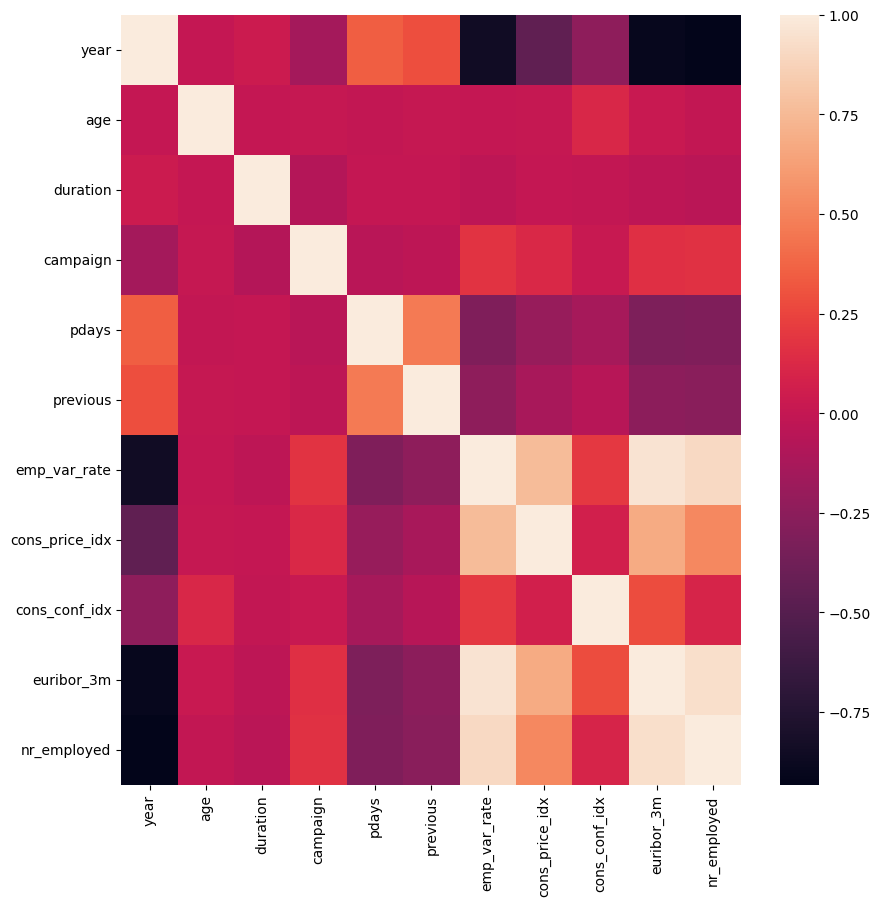

In [65]:
correlation = pdf.corr()
plt.figure(figsize = (10,10))
sns.heatmap(correlation)

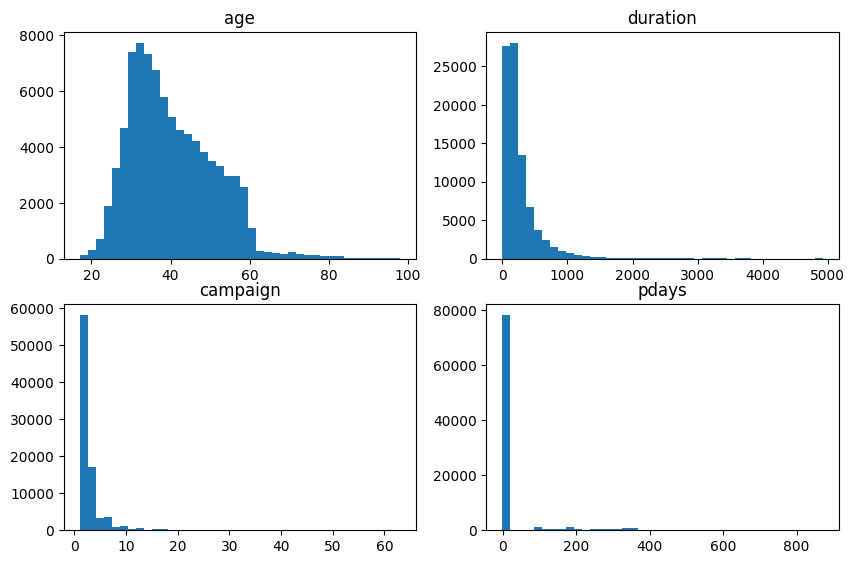

In [66]:
# Function 'plot_dist' to plot the normal distribution
def plot_dist():
    plt.figure(figsize=(10,10))
    plt.subplot(3,2,1)
    plt.hist(pdf["age"], bins = 40)
    plt.title('age')

    plt.subplot(3,2,2)
    plt.hist(pdf["duration"], bins = 40)
    plt.title('duration')

    plt.subplot(3,2,3)
    plt.hist(pdf["campaign"], bins = 40)
    plt.title('campaign')
    
    plt.subplot(3,2,4)
    plt.hist(pdf["pdays"], bins = 40)
    plt.title('pdays')
         
plot_dist()

### Ordinal Data Encoding

In [67]:
# Conversion into categorical numeric values on basis of job profile

# Creating a dictionary for converting categorical textual data entries
job_dict = {"entrepreneur":11, "self-employed":10,
            "admin":9, "management":8, "services":7,
            "technician":6, "blue-collar":5, "housemaid":4,
            "retired":3, "student":2, "unemployed":1}

for key, value in job_dict.items():
    bank_data = bank_data.withColumn("job",
                                     when(bank_data["job"] == key, int(value)) \
                                     .otherwise(bank_data["job"]))

In [68]:
# Conversion into categorical numeric values on basis of marital status
marital_dict = {"married":3, "single":2, "divorced":1}

for key, value in marital_dict.items():
    bank_data = bank_data.withColumn("marital",
                                     when(bank_data["marital"] == key, value).\
                                     otherwise(bank_data["marital"]))

In [69]:
# conversion into categorical numeric values on basis of education
edu_dict = { "professional_course":10, "university_degree":9,
            "tertiary":8, "secondary":7, "high_school":6, "basic_9y":5,
            "basic_6y":4, "primary":3, "basic_4y":2, "illiterate":1 }

for key, value in edu_dict.items():
    bank_data = bank_data.withColumn("education",
                                     when(bank_data["education"] == key, value) \
                                     .otherwise(bank_data["education"]))

In [70]:
y_dict = { "yes":1, "no":0 }

for key, value in y_dict.items():
    bank_data = bank_data.withColumn("y",
                                     when(bank_data["y"] == key, value) \
                                     .otherwise(bank_data["y"]))

In [71]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,58,8,3,8,no,yes,no,cellular,may,261,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0
2008,44,6,2,7,no,yes,no,cellular,may,151,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0
2008,33,11,3,7,no,yes,yes,cellular,may,76,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0
2008,47,5,3,7,no,yes,no,cellular,may,92,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0
2008,33,5,2,7,no,no,no,cellular,may,198,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0


In [72]:
# Convert months into the respective quarters
quarter_dict = {"jan":"Q1", "feb":"Q1", "mar":"Q1",
                "apr":"Q2", "may":"Q2", "jun":"Q2", 
                "jul":"Q3", "aug":"Q3", "sep":"Q3",
                "oct":"Q4", "nov":"Q4", "dec":"Q4"}

for key, value in quarter_dict.items():
    bank_data = bank_data.withColumn("month",
                                     when( bank_data["month"] == key, value ) \
                                     .otherwise(bank_data["month"]))

In [73]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: long (nullable = true)
 |-- job: string (nullable = false)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = false)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = false)
 |-- loan: string (nullable = false)
 |-- contact: string (nullable = false)
 |-- month: string (nullable = false)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- emp_var_rate: double (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: string (nullable = false)



In [74]:
bank = bank_data

### One Hot Encoding

In [75]:
# One hot encoding on the nominal data
one_hot_cols = ["default", "housing", "loan"]

for i in one_hot_cols:
    bank = bank.withColumn(i,
                           when(col(i) == "yes", 1) \
                           .when(col(i) == "no", 0) \
                           .otherwise(col(i)))
    
bank = bank.withColumn("contact",
                       when(col("contact") == "telephone", 1) \
                       .when(col("contact") == "cellular", 0) \
                       .otherwise(col("contact")))

In [78]:
indexer = StringIndexer(inputCol = 'month',
                        outputCol = 'class_numeric')
indexer_fitted = indexer.fit(bank)
df_indexed = indexer_fitted.transform(bank)

encoder = OneHotEncoder(inputCols = ['class_numeric'],
                        outputCols = ['class_onehot'] )
df_onehot = encoder.fit( df_indexed ).transform( df_indexed )

df_col_onehot = df_onehot.select('*',
                                 vector_to_array('class_onehot') \
                                 .alias('Quarter'))

num_categories = len(df_col_onehot.first()['Quarter'])
cols_expanded = [(col('Quarter')[i] \
                  .alias(f'{indexer_fitted.labels[i]}')) \
                 for i in range(num_categories)]
bank_df = df_col_onehot.select("year", "age", "job", "marital",
                               "education", "default", "housing", "loan",
                               "contact", "month", "duration", "campaign",
                               "pdays", "previous", "emp_var_rate", "cons_price_idx",
                               "cons_conf_idx", "euribor_3m", "nr_employed", "y", *cols_expanded)


In [80]:
display(bank_df.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,58,8,3,8,0,1,0,0,Q2,261,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0
2008,44,6,2,7,0,1,0,0,Q2,151,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0
2008,33,11,3,7,0,1,1,0,Q2,76,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0
2008,47,5,3,7,0,1,0,0,Q2,92,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0
2008,33,5,2,7,0,0,0,0,Q2,198,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0


In [81]:
bank_df.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: long (nullable = true)
 |-- job: string (nullable = false)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = false)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = false)
 |-- loan: string (nullable = false)
 |-- contact: string (nullable = false)
 |-- month: string (nullable = false)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- emp_var_rate: double (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: string (nullable = false)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



In [82]:
bank_data = bank_df

In [83]:
bank_data = bank_data.drop("month")

### Converting string datatype to double

In [84]:
column_types = bank_data.dtypes
# Filter the list to only include the string datatype columns

string_columns = [column[0] for column in column_types if column[1] == "string"]
print(string_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']


In [85]:
for cols in string_columns:
# Change the datatype of the columns to double
    bank_data = bank_data.withColumn(cols, bank_data[cols].cast("double"))

In [86]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,58,8.0,3.0,8.0,0.0,1.0,0.0,0.0,261,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,44,6.0,2.0,7.0,0.0,1.0,0.0,0.0,151,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,33,11.0,3.0,7.0,0.0,1.0,1.0,0.0,76,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,47,5.0,3.0,7.0,0.0,1.0,0.0,0.0,92,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,33,5.0,2.0,7.0,0.0,0.0,0.0,0.0,198,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0


In [87]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: long (nullable = true)
 |-- job: double (nullable = true)
 |-- marital: double (nullable = true)
 |-- education: double (nullable = true)
 |-- default: double (nullable = true)
 |-- housing: double (nullable = true)
 |-- loan: double (nullable = true)
 |-- contact: double (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- emp_var_rate: double (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: double (nullable = true)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



### Outliers visualization and removal

In [88]:
out = bank_data.toPandas()

In [89]:
outliers_columns = ["age", "duration", "campaign", "pdays", "previous"]

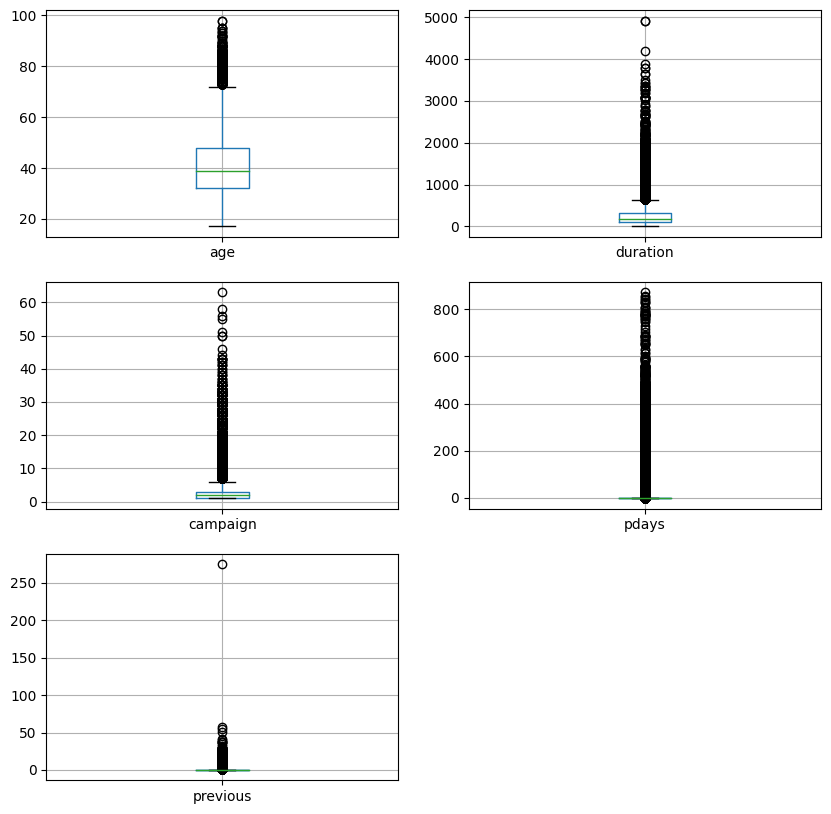

In [90]:
# Function 'plot_box' to plot the outliers
def plot_box():
    plt.figure(figsize=(10,10))
    plt.subplot(3,2,1)
    out.boxplot(column=["age"])

    plt.subplot(3,2,2)
    out.boxplot(column=["duration"])

    plt.subplot(3,2,3)
    out.boxplot(column=["campaign"])

    plt.subplot(3,2,4)
    out.boxplot(column=["pdays"])

    plt.subplot(3,2,5)
    out.boxplot(column=["previous"])
           
plot_box()

In [91]:
# Removing the outliers with the help of maximum binding limit
max_out_limit = []
for cols in outliers_columns:
    quantiles = bank_data.approxQuantile(cols, [0.25, 0.5, 0.75], 0.01)
    
    q3 = quantiles[2]
    q1 = quantiles[0]
    iqr = q3 - q1
    iqr = iqr*1.5
    max_limit = q3 + iqr
    min_limit = q1 - iqr
    max_out_limit.append(max_limit)
    
    print(cols, "max_limit: ", max_limit, "      min_limit: ", min_limit)
else:
    print("------------------------------------------")
    print(max_out_limit)



age max_limit:  69.5       min_limit:  9.5
duration max_limit:  631.0       min_limit:  -217.0
campaign max_limit:  6.0       min_limit:  -2.0
pdays max_limit:  -1.0       min_limit:  -1.0
previous max_limit:  0.0       min_limit:  0.0
------------------------------------------
[69.5, 631.0, 6.0, -1.0, 0.0]


In [92]:
for i, j in zip(outliers_columns, max_out_limit):
    bank_data = bank_data.withColumn(i,
                                     when( (col(i) >= j), j) \
                                     .otherwise(col(i))) 

In [93]:
out = bank_data.toPandas()

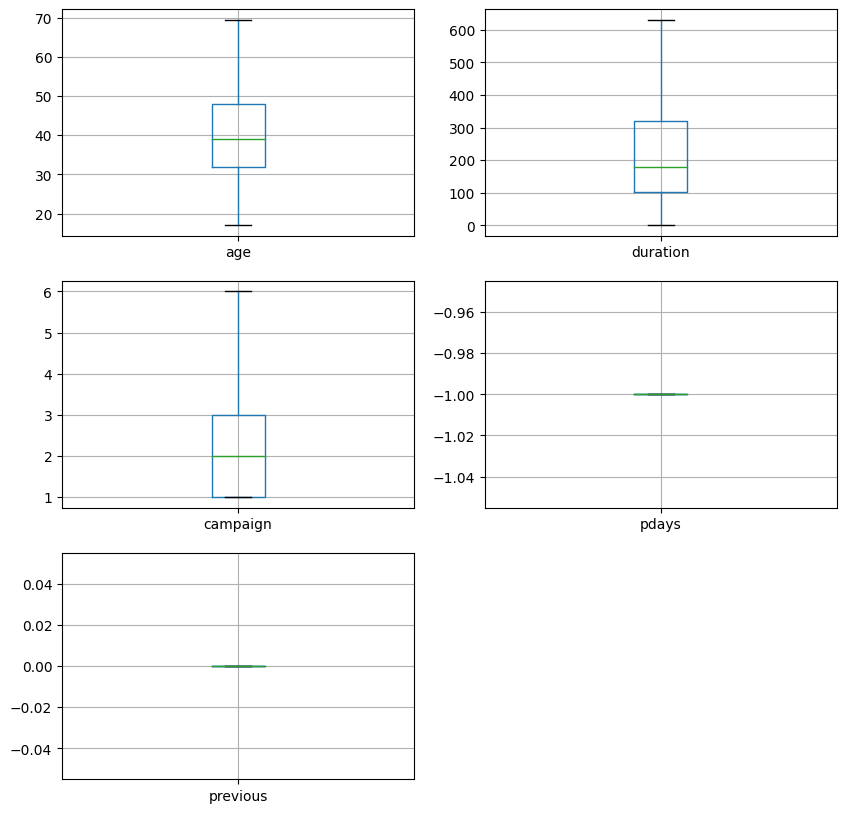

In [94]:
plot_box()

In [95]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: double (nullable = true)
 |-- job: double (nullable = true)
 |-- marital: double (nullable = true)
 |-- education: double (nullable = true)
 |-- default: double (nullable = true)
 |-- housing: double (nullable = true)
 |-- loan: double (nullable = true)
 |-- contact: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- emp_var_rate: double (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: double (nullable = true)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



## PySpark Model Building

In [96]:
bank = bank_data

In [97]:
display(bank.limit(5))

year,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,58.0,8.0,3.0,8.0,0.0,1.0,0.0,0.0,261.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,44.0,6.0,2.0,7.0,0.0,1.0,0.0,0.0,151.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,33.0,11.0,3.0,7.0,0.0,1.0,1.0,0.0,76.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,47.0,5.0,3.0,7.0,0.0,1.0,0.0,0.0,92.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,33.0,5.0,2.0,7.0,0.0,0.0,0.0,0.0,198.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0


In [98]:
bank.groupBy("y").count().show()

+---+-----+
|  y|count|
+---+-----+
|0.0|76470|
|1.0| 9929|
+---+-----+



*OBSERVATION :* <br><br>
We have excess count of 0 i.e. (no) in 'y' so the dataset is imblanced. <br>
Hence, we are going for oversampling of yes

## Data Oversampling of "yes" label in y

In [99]:
# Data oversampling function of the "yes" lebel in the dependent column
def over_sample( data, oversampling_ratio ):
    import math

    # avoid changing the original object accidentally
    new_data = data.toPandas()
    

    nums = new_data['y'].value_counts()
    num_n = nums[0]
    num_y = nums[1]
    nums = len(new_data["y"])

    new_y = ( (1 - oversampling_ratio) / oversampling_ratio)*num_n
   
    loop_num = int( math.ceil(new_y/num_y) )

    new_df = new_data[ new_data["y"] == 1.0 ]
   
    for i in range(0, loop_num-1):
       
        # randomly select all rows from new_df
        random_rows = new_df.sample(n = num_y, replace = True, random_state = 14)
        
        # append the selected row to bank_df
        new_data = new_data.append(random_rows, ignore_index=True)
       
    new_data = spark.createDataFrame(new_data)
    return new_data

In [100]:
bank_oversampled_df = over_sample(data = bank, oversampling_ratio = 0.6)

In [101]:
# Value counts for y column
bank_oversampled_df.groupBy("y").count().show()

+---+-----+
|  y|count|
+---+-----+
|0.0|76470|
|1.0|59574|
+---+-----+



In [102]:
bank = bank_oversampled_df

## Data Scaling

In [103]:
# Min_max scaling for the selected columns

numerical_cols = ['year', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 
                  'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 
                  'nr_employed', 'Q2', 'Q3', 'Q4']

#numerical_cols = ['year', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 
                   #'cons_price_idx', 'Q4']

# Create a vector assembler to combine the numerical columns into a single vector
assembler = VectorAssembler(inputCols = numerical_cols,
                            outputCol = "numerical_features")

# Transform the DataFrame to create the numerical features vector
bank = assembler.transform(bank)

# Apply MinMaxScaler to the numerical features vector
scaler = MinMaxScaler(inputCol = "numerical_features",
                      outputCol = "scaled_numerical_features")
scaler_model = scaler.fit(bank)
df = scaler_model.transform(bank)
df = df.drop("numerical_features")

# Drop the original numerical columns and keep only the scaled numerical features
bank = df.drop(*numerical_cols) \
       .withColumnRenamed("scaled_numerical_features", "sc_features")

In [104]:
display(bank.limit(5))

campaign,pdays,previous,y,sc_features
1.0,-1.0,0.0,0.0,"[0.0,0.7809523809..."
1.0,-1.0,0.0,0.0,"[0.0,0.5142857142..."
1.0,-1.0,0.0,0.0,"[0.0,0.3047619047..."
1.0,-1.0,0.0,0.0,"[0.0,0.5714285714..."
1.0,-1.0,0.0,0.0,"[0.0,0.3047619047..."


In [105]:
banks = bank

In [106]:
display(banks.limit(5))

campaign,pdays,previous,y,sc_features
1.0,-1.0,0.0,0.0,"[0.0,0.7809523809..."
1.0,-1.0,0.0,0.0,"[0.0,0.5142857142..."
1.0,-1.0,0.0,0.0,"[0.0,0.3047619047..."
1.0,-1.0,0.0,0.0,"[0.0,0.5714285714..."
1.0,-1.0,0.0,0.0,"[0.0,0.3047619047..."


In [107]:
# Get the names of columns of the dataframe
feature = []
for columns in banks.columns:
    feature.append(columns)
else:
    print(feature)

['campaign', 'pdays', 'previous', 'y', 'sc_features']


In [108]:
banks.count()

136044

In [109]:
# Train Test Split: train data percentage: 70% and test data percentage: 30%
train_data, test_data = banks.randomSplit([0.70, 0.30], seed = 14)
display(train_data.limit(5))

campaign,pdays,previous,y,sc_features
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."


In [110]:
# Train data count
train_data.count()

95006

In [111]:
# Test data count
test_data.count()

41038

## 1. Decision Tree Classifier

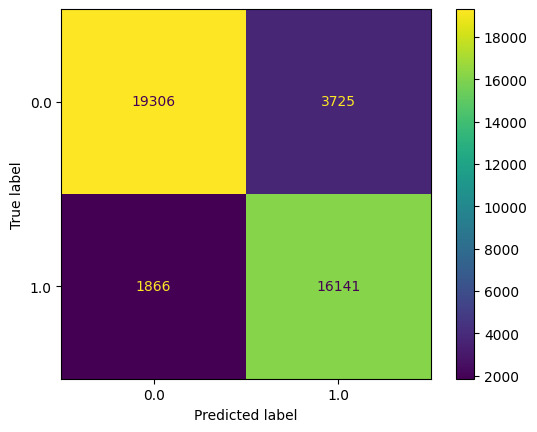

In [112]:
dt = DecisionTreeClassifier(labelCol = "y",
                            featuresCol = 'sc_features')
dt_model = dt.fit(train_data)

# Predict the values on test data
dt_predictions = dt_model.transform(test_data)

dt_pred = dt_predictions.select('prediction').toPandas()
actual = dt_predictions.select('y').toPandas()

# Show Confusion matrix
ConfusionMatrixDisplay.from_predictions(actual, dt_pred)

In [113]:
# Print Classification Report for Decision Tree
print(classification_report(actual, dt_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87     23031
         1.0       0.81      0.90      0.85     18007

    accuracy                           0.86     41038
   macro avg       0.86      0.87      0.86     41038
weighted avg       0.87      0.86      0.86     41038



## 2. Logistic Regression

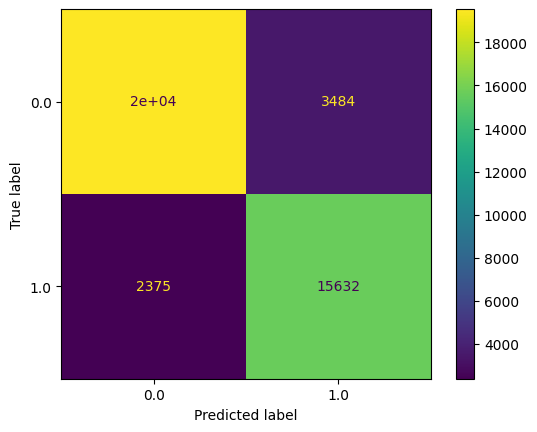

In [114]:
lr = LogisticRegression(featuresCol = 'sc_features',
                        labelCol = 'y',
                        maxIter = 1000)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

lr_pred = lr_predictions.select('prediction').toPandas()
actual = lr_predictions.select('y').toPandas()

# Show Confusion matrix
ConfusionMatrixDisplay.from_predictions(actual, lr_pred)

In [115]:
# Print Classification Report for Logistic Regression
print(classification_report(actual, lr_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87     23031
         1.0       0.82      0.87      0.84     18007

    accuracy                           0.86     41038
   macro avg       0.85      0.86      0.86     41038
weighted avg       0.86      0.86      0.86     41038



## 3. Support Vector Machines

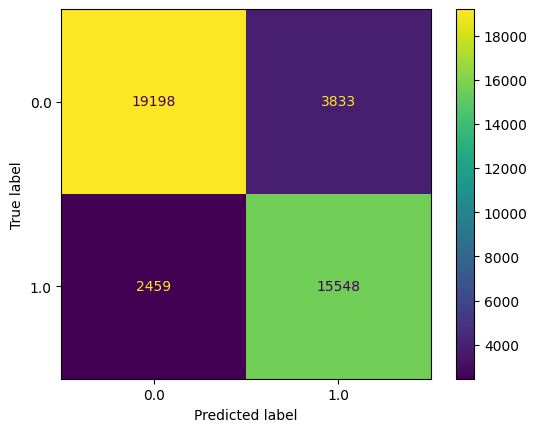

In [116]:
# Load training data
lsvc = LinearSVC(featuresCol = 'sc_features',
                 labelCol = 'y',
                 maxIter = 10, regParam = 0.1)

# Fit the model
lsvcModel = lsvc.fit(train_data)

svc_predictions = lsvcModel.transform(test_data)

svc_pred = svc_predictions.select('prediction').toPandas()
actual = svc_predictions.select('y').toPandas()

# Show Confusion matrix
ConfusionMatrixDisplay.from_predictions(actual, svc_pred)

In [117]:
# Print Classification Report for Support Vector Classifier
print(classification_report(actual, svc_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86     23031
         1.0       0.80      0.86      0.83     18007

    accuracy                           0.85     41038
   macro avg       0.84      0.85      0.85     41038
weighted avg       0.85      0.85      0.85     41038



## 4. Random Forest

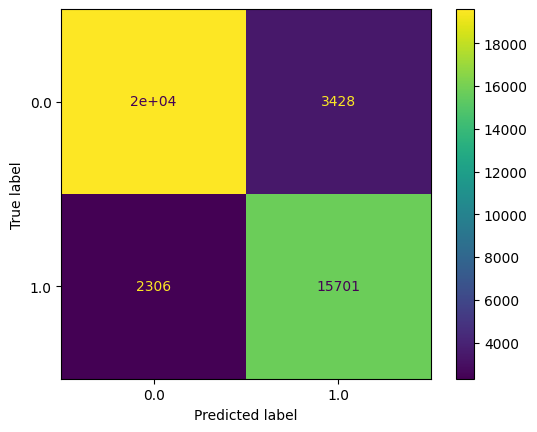

In [118]:
rf = RandomForestClassifier(labelCol='y',
                            featuresCol = 'sc_features')

rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)

rf_prediction = rf_model.transform(test_data)

rf_preds = rf_prediction.select('prediction').toPandas()
actual = rf_prediction.select('y').toPandas()

# Show Confusion matrix
ConfusionMatrixDisplay.from_predictions(actual, rf_preds)

In [119]:
# Print Classification Report for Random Forest
print(classification_report(actual, rf_preds))

              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87     23031
         1.0       0.82      0.87      0.85     18007

    accuracy                           0.86     41038
   macro avg       0.86      0.86      0.86     41038
weighted avg       0.86      0.86      0.86     41038



## Hyper-parameter Tuning

### 1. Hyper-parameter tuning for Random forest

In [120]:
# Define parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

# Define evaluator
evaluator = BinaryClassificationEvaluator(metricName = "areaUnderROC",
                                          labelCol = lr.getLabelCol())

# Define cross-validator
cv = CrossValidator(estimator = rf, estimatorParamMaps = param_grid,
                    evaluator = evaluator, numFolds = 5)

# Fit cross-validator to training data
cv_model = cv.fit(train_data)

# Evaluate model on test data
gcv_pred = cv_model.transform(test_data)
evaluator.evaluate(predictions)

0.924930806859621

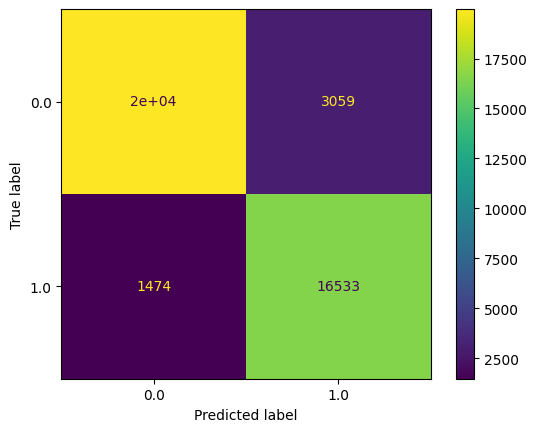

In [121]:
gcv_preds = gcv_pred.select('prediction').toPandas()
gcv_actual = gcv_pred.select('y').toPandas()

ConfusionMatrixDisplay.from_predictions(gcv_actual, gcv_preds)

In [122]:
# Print Classification Report for tuned RandomForest
print(classification_report(gcv_actual, gcv_preds))

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90     23031
         1.0       0.84      0.92      0.88     18007

    accuracy                           0.89     41038
   macro avg       0.89      0.89      0.89     41038
weighted avg       0.89      0.89      0.89     41038



### 2. Hyper-parameter tuning for Decision Tree

In [123]:
# Define parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

# Define evaluator
evaluator = BinaryClassificationEvaluator(metricName = "areaUnderROC",
                                          labelCol = dt.getLabelCol())

# Define cross-validator
cv = CrossValidator(estimator = dt, estimatorParamMaps = param_grid,
                    evaluator = evaluator, numFolds = 5)

# Fit cross-validator to training data
cv_model = cv.fit(train_data)

# Evaluate model on test data
gcv_dt_pred = cv_model.transform(test_data)
evaluator.evaluate(predictions)

0.9249308068596211

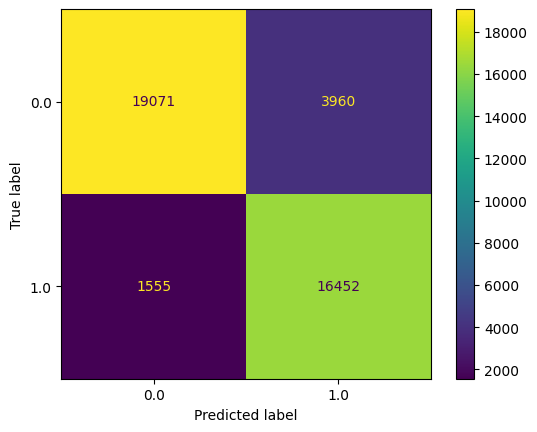

In [124]:
gcv_preds = gcv_dt_pred.select('prediction').toPandas()
gcv_actual = gcv_dt_pred.select('y').toPandas()

ConfusionMatrixDisplay.from_predictions(gcv_actual, gcv_preds)

In [127]:
# Print Classification Report for tuned Decision Tree
print("Hyperparameter tuned Decision Tree Classification Report \n\n",
      classification_report(gcv_actual, gcv_preds))

Hyperparameter tuned Decision Tree Classification Report 

               precision    recall  f1-score   support

         0.0       0.92      0.83      0.87     23031
         1.0       0.81      0.91      0.86     18007

    accuracy                           0.87     41038
   macro avg       0.87      0.87      0.87     41038
weighted avg       0.87      0.87      0.87     41038



### 3. Hyper-parameter tuned Logistic Regression

In [ ]:
# Define parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

# Define evaluator
evaluator = BinaryClassificationEvaluator(metricName = "areaUnderROC",
                                          labelCol = dt.getLabelCol())

# Define cross-validator
cv = CrossValidator(estimator = dt, estimatorParamMaps = param_grid,
                    evaluator = evaluator, numFolds = 5)

# Fit cross-validator to training data
cv_model = cv.fit(train_data)

# Evaluate model on test data
gcv_dt_pred = cv_model.transform(test_data)
evaluator.evaluate(predictions)